In [4]:
from devito import Grid, Function,TimeFunction, Eq, Operator, configuration, Eq, solve
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# Parameters
nx = 300
ny = 300
nt  = int(1e5)
xmin = -1.
ymin = -1.
xmax = 1.
ymax = 1.
extent = (xmin, xmax, ymin, ymax)

# Wave speed
a1 = 2.
a2 = 2.
k = 1.

# Create the grid
grid = Grid(shape=(nx, ny), extent=(xmax - xmin, ymax - ymin))
x, y = grid.dimensions
t = grid.stepping_dim

In [57]:
p = TimeFunction(name='p', grid=grid, space_order=2)
p.data[:] = 0.

In [58]:
# Create the source term
b = Function(name='b', grid=grid, space_order=2)
x_vals = np.linspace(xmin, xmax, nx)
y_vals = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x_vals, y_vals)
b.data[:] = (k**2 - (a1 * np.pi)**2 - (a2 * np.pi)**2) * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

In [68]:
stencil

-0.5*(h_x**2*h_y**2*b(x, y) - h_x**2*p(t, x, y - h_y) - h_x**2*p(t, x, y + h_y) - h_y**2*p(t, x - h_x, y) - h_y**2*p(t, x + h_x, y))/(h_x**2 + h_y**2)

In [69]:
# Create Laplace equation base on `p`
eq = Eq((p.laplace - b)/k**2, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eq,p)
# Let our stencil populate the buffer `p.forward`
eq_stencil = Eq(p, stencil)
eq_stencil

Eq(p(t, x, y), -0.5*(h_x**2*h_y**2*b(x, y) - h_x**2*p(t, x, y - h_y) - h_x**2*p(t, x, y + h_y) - h_y**2*p(t, x - h_x, y) - h_y**2*p(t, x + h_x, y))/(h_x**2 + h_y**2))

In [60]:
# Create the boundary condition
bc = [Eq(p[t + 1, x, 0], 0.)]
bc += [Eq(p[t + 1, x, ny-1], 0.)]
bc += [Eq(p[t + 1, 0, y], 0.)]
bc += [Eq(p[t + 1, nx-1, y], 0.)]

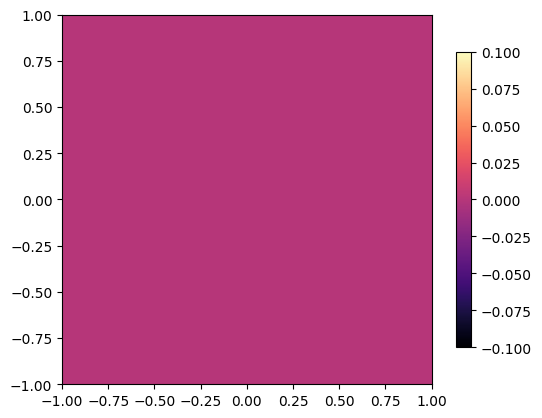

In [61]:
plt.imshow(p.data[0], cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)

In [62]:
#NBVAL_IGNORE_OUTPUT
configuration['log-level'] = 'ERROR'
# Create and execute the operator for a number of timesteps
op = Operator([eq_stencil] + bc)
%time op(time=nt)

CPU times: user 25.6 s, sys: 2.25 ms, total: 25.6 s
Wall time: 25.6 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=25.533495000009108, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.05631400000003444, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0046130000000002775, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

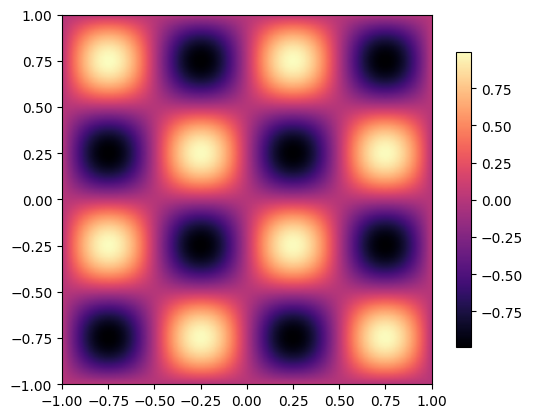

In [63]:
plt.imshow(p.data[nt], cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)

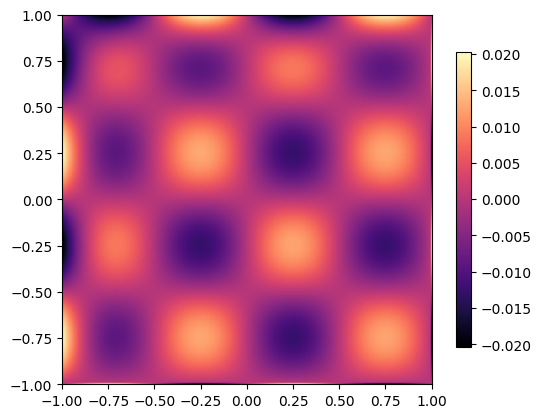

In [64]:
u_exact = np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)


plt.imshow(u_exact - p.data[nt], cmap='magma', extent=extent)
plt.colorbar(shrink=0.8)
plt.show()

In [65]:
# Calculate the error relativo
error = np.linalg.norm(p.data[nt].flatten() - u_exact.flatten()) / np.linalg.norm(u_exact.flatten())
print('Relative error norm: %2.2f' %
      (error))
 

Relative error norm: 0.01
